In [30]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from model_zoo import my_lgb,my_xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [9]:
train_df = pd.read_csv('dataset/train_dataset.csv')
test_df = pd.read_csv('dataset/test_dataset.csv')

In [3]:
train_df['用户近6个月平均消费值（元）'] = train_df['用户近6个月平均消费值（元）'].astype(int)
test_df['用户近6个月平均消费值（元）'] = test_df['用户近6个月平均消费值（元）'].astype(int)

In [4]:
# train_df['用户账单当月总费用（元）'].astype(int).value_counts()
train_df['用户账单当月总费用（元）'] = train_df['用户账单当月总费用（元）'].astype(int)
test_df['用户账单当月总费用（元）'] = test_df['用户账单当月总费用（元）'].astype(int)

In [10]:
# 用户开始上网的年龄
train_df['开始上网的年龄(月)'] = train_df['用户年龄'] - (train_df['用户网龄（月）']/12).astype(int)
test_df['开始上网的年龄(月)'] = test_df['用户年龄'] - (test_df['用户网龄（月）']/12).astype(int)

# 将所有应用使用次数求和
app_col = []
for col in train_df.columns:
    if '应用' in col:
        app_col.append(col)
train_df['各类应用使用总和'] = train_df[app_col].sum(axis=1)
test_df['各类应用使用总和'] = test_df[app_col].sum(axis=1)

In [38]:
#丢掉重要程度小的数据
drop_col = ['当月是否逛过福州仓山万达', '当月是否到过福州山姆会员店', '是否黑名单客户', '用户实名制是否通过核实', '是否大学生客户']

train_df.drop(columns=drop_col, inplace=True)
test_df.drop(columns=drop_col, inplace=True)

In [131]:
train_df.shape

(50000, 32)

In [11]:
# model_1
X_train = train_df.drop(columns=['用户编码', '信用分']).values
y_train = train_df['信用分'].values
X_test = test_df.drop(columns='用户编码').values

param = {'num_leaves': 40,
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.5,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [12]:
xgb_params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.5,
              'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 4}

In [13]:
clf = my_lgb(5)
clf.inference_folds(X_train, y_train, X_test, param)

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l1: 16.339	valid_1's l1: 16.5297
[400]	training's l1: 14.6889	valid_1's l1: 15.0763
[600]	training's l1: 14.2989	valid_1's l1: 14.8638
[800]	training's l1: 14.0453	valid_1's l1: 14.7699
[1000]	training's l1: 13.8535	valid_1's l1: 14.7369
[1200]	training's l1: 13.6857	valid_1's l1: 14.7204
[1400]	training's l1: 13.527	valid_1's l1: 14.7105
[1600]	training's l1: 13.3816	valid_1's l1: 14.7029
[1800]	training's l1: 13.245	valid_1's l1: 14.7034
Early stopping, best iteration is:
[1731]	training's l1: 13.291	valid_1's l1: 14.7004
fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l1: 16.3918	valid_1's l1: 16.3501
[400]	training's l1: 14.7443	valid_1's l1: 14.9177
[600]	training's l1: 14.35	valid_1's l1: 14.6945
[800]	training's l1: 14.093	valid_1's l1: 14.6049
[1000]	training's l1: 13.8971	valid_1's l1: 14.5669
[1200]	training's l1: 13.7258	valid_1's l1: 14.5456
[140

In [99]:
f = clf.importance_feature(train_df.drop(columns=['用户编码', '信用分']).columns)
f

,score
用户近6个月平均消费值（元）,10653
用户网龄（月）,9483
用户账单当月总费用（元）,7286
当月通话交往圈人数,7153
用户年龄,6586
各类应用使用总和,4610
当月网购类应用使用次数,4491
当月金融理财类应用使用总次数,4489
开始上网的年龄(月),4487
用户当月账户余额（元）,4379


E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


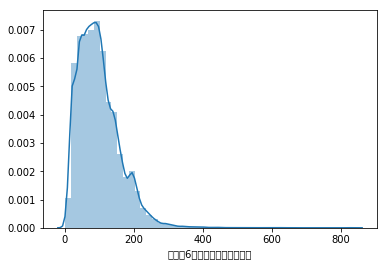

In [108]:
sns.distplot(train_df['用户近6个月平均消费值（元）'])
plt.show()

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


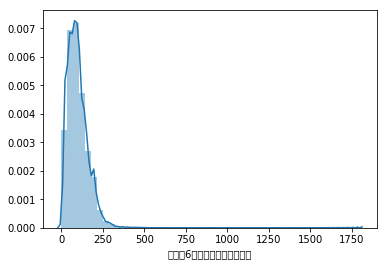

In [109]:
sns.distplot(test_df['用户近6个月平均消费值（元）'])
plt.show()

In [50]:
cost = train_df.groupby(by='用户近6个月平均消费值（元）')['信用分'].mean()

In [57]:
train_df['用户近6个月平均消费值（元）'].astype(int).value_counts()

18.00     198
38.00     105
40.00      77
18.01      75
38.01      62
88.00      61
18.03      58
60.00      51
90.00      45
38.03      44
30.00      44
98.00      42
20.00      42
18.04      39
58.00      36
38.04      36
68.00      35
21.00      35
38.06      32
41.00      31
24.00      28
50.00      26
18.07      26
55.14      25
18.11      25
18.10      24
18.06      23
78.00      23
40.01      22
38.07      22
         ... 
82.53       1
284.98      1
196.10      1
107.69      1
162.40      1
277.37      1
134.61      1
72.62       1
214.58      1
173.55      1
268.09      1
23.18       1
225.52      1
340.70      1
80.56       1
148.36      1
116.22      1
205.40      1
89.82       1
190.82      1
137.33      1
115.54      1
130.69      1
146.22      1
279.79      1
211.75      1
137.34      1
187.47      1
154.92      1
237.37      1
Name: 用户近6个月平均消费值（元）, Length: 18267, dtype: int64